In [ ]:
#-----------------------------------* FIRST ATTEMPT *---------------------------------------
# Problem description: develop a forecasting model that is able to predict several uncorrelated time series

# DATA STRUCTURE:
# Single folder containing the following files:
# -> 'training_data.npy': it contains a numpy array of shape (48000, 2776). 48000 time series of length 2776.
# -> 'valid_periods.npy': it contains a numpy array of type (48000, 2) containing for each of the time series the start and end index of the current series, i.e. the part without padding.
# -> 'categories.npy': it contains a numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.
# IMPORTANT: This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
# What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set.

In [ ]:
# Import libraries and connect to drive personal folder

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/homework_2/Edoardo

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras import backend as K
from keras.callbacks import TensorBoard
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)


# Import other support libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


Mounted at /gdrive
/gdrive/My Drive/homework_2/Edoardo
2.14.0


In [ ]:
# Define function for data inport:
# The function takes as input the path of the folder containing the data and returns the training data, the validation periods and the categories
# Before doing so, it eventually unzips it if the zip flag is set to True

def import_data(path, zip=False):
    if zip:
        !unzip -q $path
    training_data = np.load('training_data.npy')
    valid_periods = np.load('valid_periods.npy')
    categories = np.load('categories.npy')
    return training_data, valid_periods, categories

# Call the function to import the data
training_data, valid_periods, categories = import_data('training_dataset.zip', zip=False)

# Check the shape of the data
print(training_data.shape)
print(valid_periods.shape)
print(categories.shape)

# Transform the data by extending the dimensions (number of time series, length of time series, number of features)
training_data = np.expand_dims(training_data, axis=2)


(48000, 2776)
(48000, 2)
(48000,)


Text(0.5, 0.98, 'First 10 time series without padding')

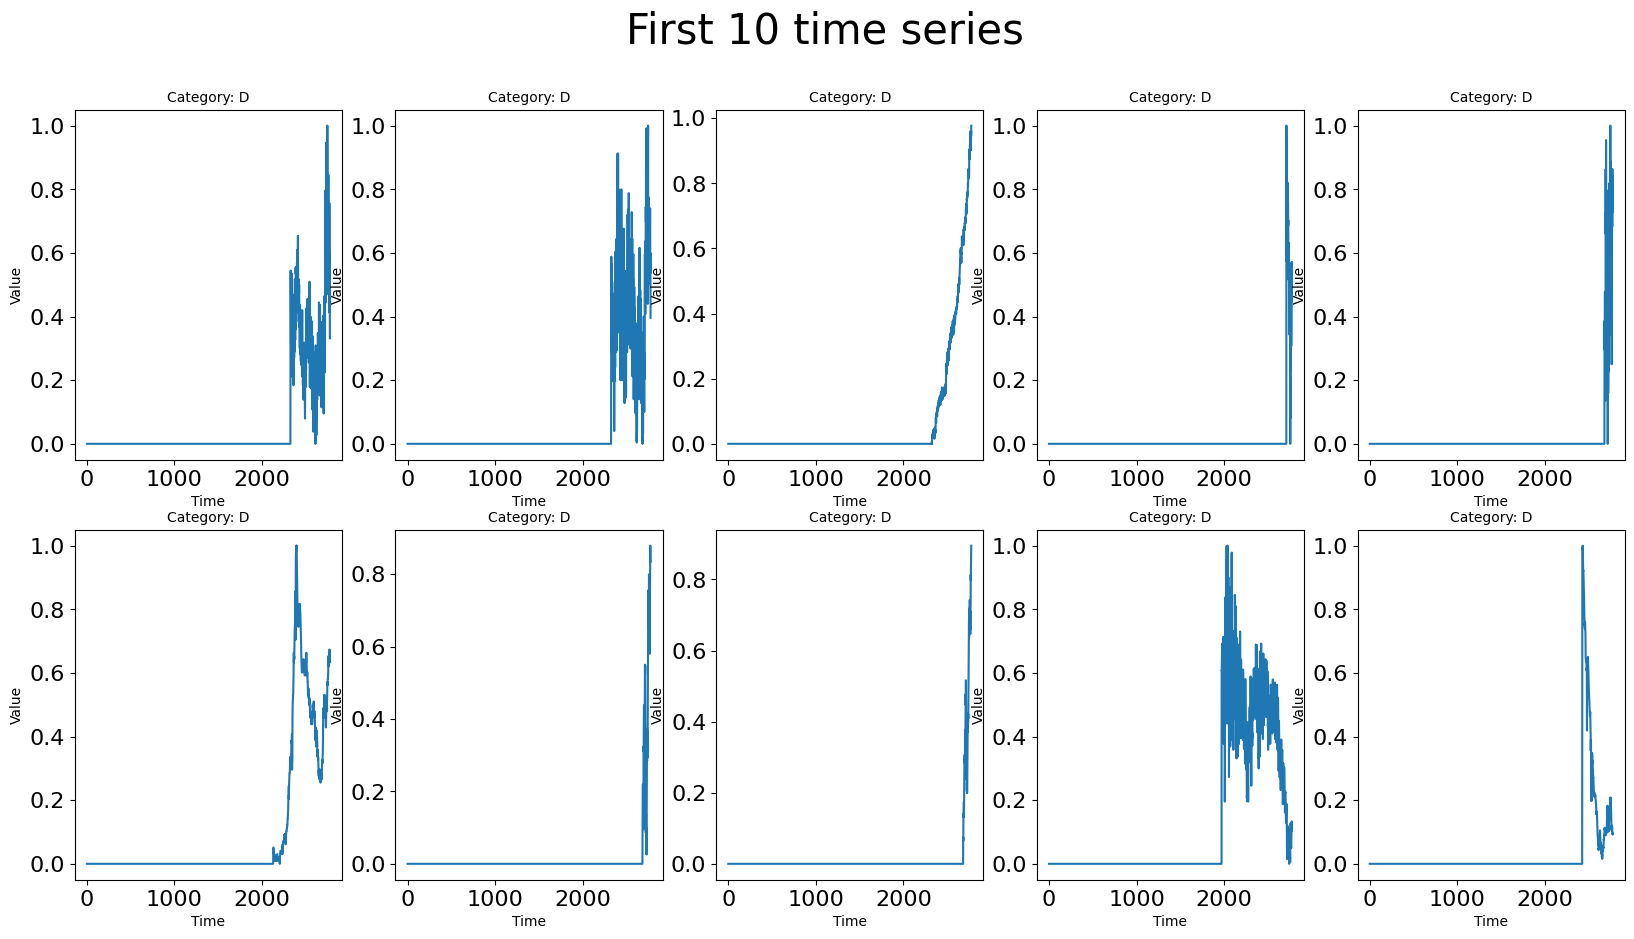

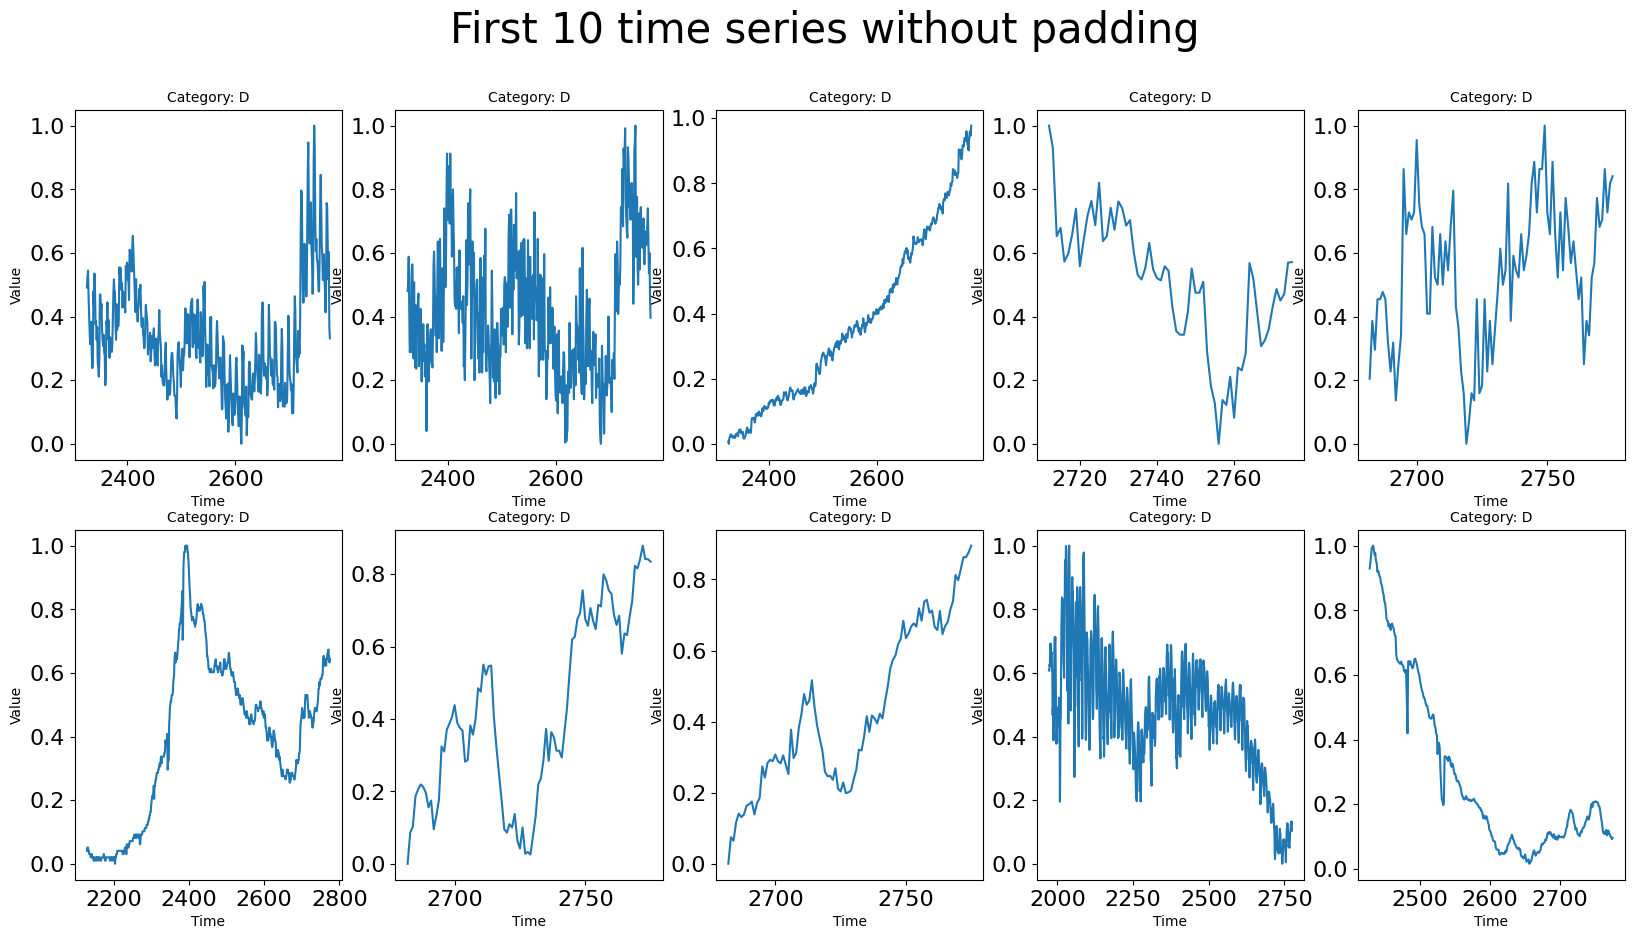

In [ ]:
# -----------------------------------* DATA ANALYSIS *---------------------------------------

# Note that all the values are store as float64, so we can convert them to float32 to save memory
if training_data.dtype == np.float64:
    training_data = training_data.astype(np.float32)

# -<-<-<-<-<-<-<-<-<-< FIRST PLOTS AND PADDING REMOVAL >->->->->->->->->->->-

# Plot the first 10 time series

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(training_data[i])
    axs[i].set_title('Category: {}'.format(categories[i]), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)

fig.suptitle('First 10 time series', fontsize=30)

# Define a function to remove the padding from the time series

def remove_padding(data, valid_periods):
    data_no_pad = []
    for i in range(data.shape[0]):
        data_no_pad.append(data[i, valid_periods[i, 0]:valid_periods[i, 1]])
    return np.array(data_no_pad)

# Remove the padding from the time series
training_data_no_pad = remove_padding(training_data, valid_periods)

# Plot the first 10 time series without padding, keeping the information about the orignal temporal location
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(range(valid_periods[i, 0], valid_periods[i, 1]), training_data_no_pad[i])
    axs[i].set_title('Category: {}'.format(categories[i]), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)

fig.suptitle('First 10 time series without padding', fontsize=30)

# All this samples belong to category D, and are "to be understood as not closely related to each other, but only as collected from similar data sources"
# This means that the time seies within the same categoty are to be considered as uncorrelated, but should there not be a correlationbetween the catoegories?


{0: 0.00017458100558659218, 1: 9.101665604805679e-05, 2: 9.98302885095338e-05, 3: 9.984025559105431e-05, 4: 9.111617312072893e-05, 5: 0.0036101083032490976}


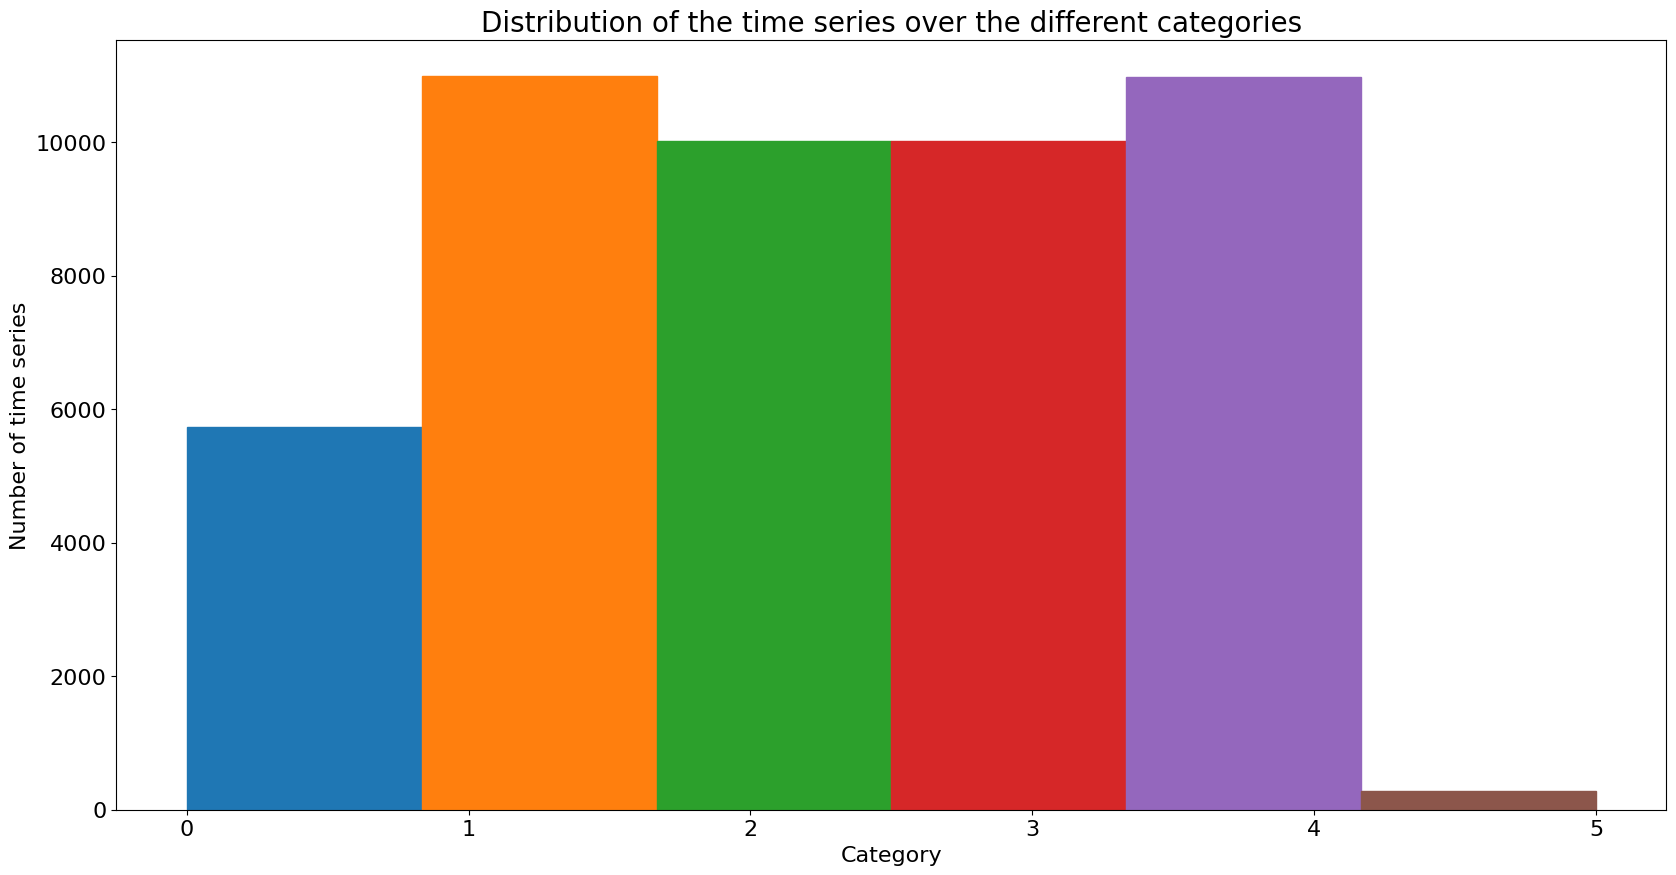

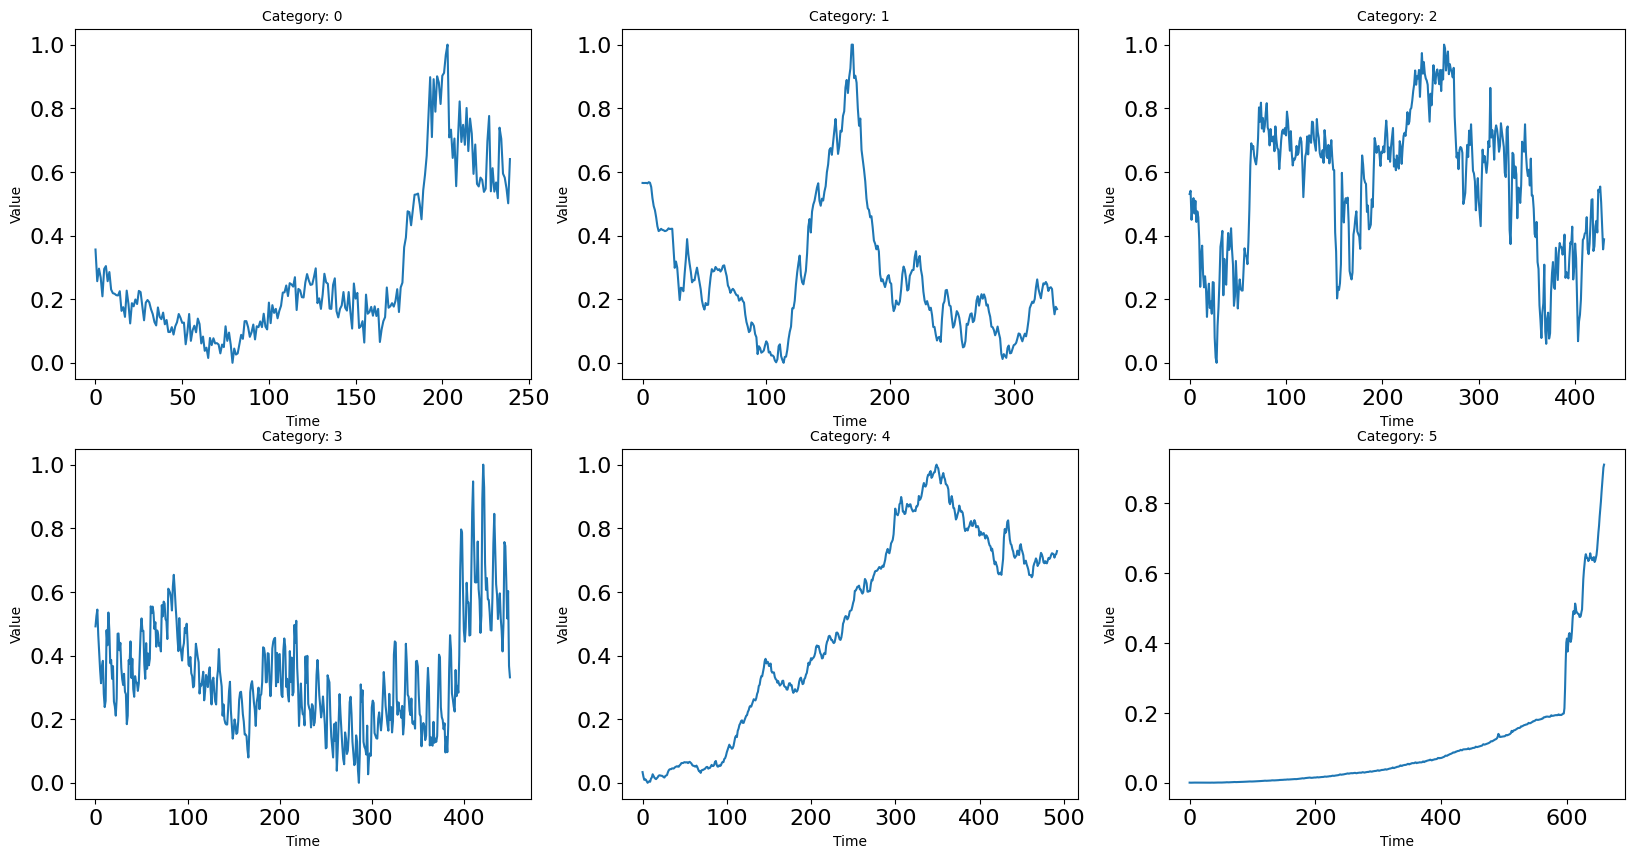

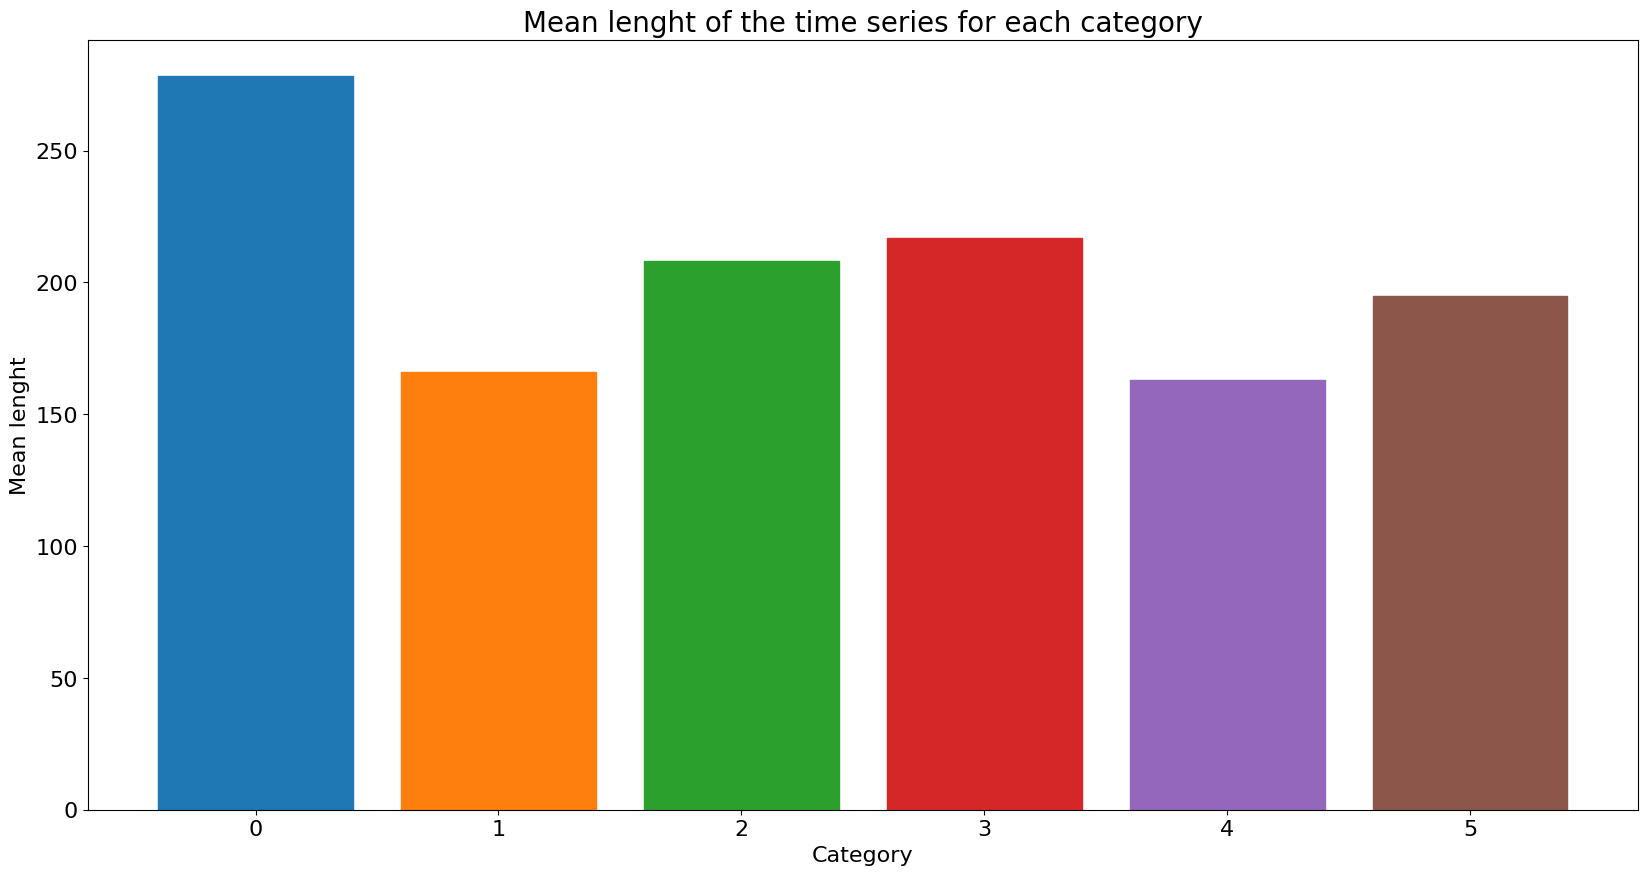

In [ ]:

# -<-<-<-<-<-<-<-<-<-< DATA DISTRIBUTION ANALYSIS >->->->->->->->->->->-


# GROUP DATA BY CATEGORY:

# Transform the categories into numbers
categorical_to_numerical = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F':5}

if categories[0] == "D":
    for category in np.unique(categories):
        categories[categories == category] = categorical_to_numerical[category]
    # To save memory, convert the categories to int32
    categories = categories.astype(np.int32)

# Now plot the distribution of the time series over the different categories
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(categories, bins=6)
ax.set_title('Distribution of the time series over the different categories', fontsize=20)
ax.set_xlabel('Category')
ax.set_ylabel('Number of time series')
# separate the bars and use different colors
for i in range(6):
    ax.patches[i].set_color('C{}'.format(i))
plt.xticks(np.arange(6))

# OSS: a visible imbalance between the categories is present, with category 5 been extremely underrepresented
# (category 1 is just slightly underrepresented, while the other categories are more or less equally represented)

# Compute class_weight paramenter to be used for the fit of the model
weights = {}
for i in range(6):
    weights[i] = 1 / np.sum(categories == i)
print(weights)



# -<-<-<-<-<-<-<-<-<-<-<-< DATA NORMLIZATION >->->->->->->->->->->->->-
# AS THE DATA HAS ALREADY BEEN NORMALIZED (EACH ROW HAS BEEN NORMALIZED INDIPENDENTLY)
# WE DEEMED THIS STEP NOT NECESSARY


# Define min_max normalization function
def min_max_norm(data, min, max):
    return (data - min) / (max - min)

# Apply the function over the categories singularly
def min_max_norm_by_category(data, categories):
    # Loop over the categories
    for category in np.unique(categories):
        # For each category compute the min and max
        C_min = np.min(data[categories == category])
        C_max = np.max(data[categories == category])
        # Apply the min_max_norm function to the data of the current category
        data[categories == category] = min_max_norm(data[categories == category], C_min, C_max)
    return data


# -<-<-<-<-<-<-< PLOT OF FIRST TIME SERIES FOR DIFFERENT CATEGORIES >->->->->->-
# Plot the first time series for each category

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()
for i in range(6):
    axs[i].plot(training_data_no_pad[categories == i][0])
    axs[i].set_title('Category: {}'.format(i), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)

# -<-<-<-<-<-<-< PLOT OF TIME SERIES BY LENGHT AND DOMAIN  >->->->->->-

# Compute mean lenght of the time series for each category and plot them in a bar plot
mean_lenght = []
for i in range(6):
    mean_lenght.append(np.mean(valid_periods[categories == i, 1] - valid_periods[categories == i, 0]))
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(np.arange(6), mean_lenght)
ax.set_title('Mean lenght of the time series for each category', fontsize=20)
ax.set_xlabel('Category')
ax.set_ylabel('Mean lenght')
plt.xticks(np.arange(6))
for i in range(6):
    ax.patches[i].set_color('C{}'.format(i))

# OSS: a fairly similar mean lenght for all the categories




In [ ]:
# Define some Hyperparameters for the forcasting model
WINDOW_SIZE = 200
BATCH_SIZE = 512
STRIDE = 10
EPOCHS = 100
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.03
TELESCOPE = 18

# In this case, given the nature of the problem, as well as the fact that the time series are not correlated
# (so introducing some of them in training phase should now bias the test), we decide
# to make use of the great variaty of time series available, and split data among the time series themselves:

# This way, a certain percentage of the time series will be used for training (80% initial partition), while the remaining ones will be used for validation (20).
# In both case, we define the number of samples to be predicted as TELESCOPE, and the number of samples to be used for the prediction as WINDOW_SIZE.

# For the testing, we respect the imbalances among the different domains using stratify based on the categories

X_train_raw, X_test_raw, domains_train, domains_test = train_test_split(training_data_no_pad, categories, test_size=TEST_SPLIT, stratify=categories)
X_train_raw, X_val_raw, domains_train, domains_val = train_test_split(X_train_raw, domains_train, test_size=VALIDATION_SPLIT, stratify=domains_train)

In [ ]:
# -----------------------------------* DATA PREPROCESSING *---------------------------------------
# Build the sequences for the forecasting model: in this case, we will try to take into account the
# imbalance between the categories usign a weighted loss function

# The function lets us build the sequences to use for the training of the forecasting model:
# In this case, given a certain domain (category), the function will build the sequences to be used for the training
# by extracting temporal windows out of each time series.
# Please note tha some of the time series will takes as they are, since they are shorter than the window size.
# In some other cases, the time series are "partioned" in windows of the same size, and the last window is padded with zeros
# In any case, for the correct creation of the sequences, dataset to be passed to the function must be the one without padding
def build_sequences_on_domain(data, categories_split  ,domain = 0, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = data[categories_split == domain]
    temp_label = temp_df.copy()
    # For each time series of the specific domain, compute the padding lenght
    # OSS... This is done on the data without padding
    for time_series_n in range(len(temp_df)):
        padding_len = (window + telescope) - len(temp_df[time_series_n])
        if(padding_len > 0):
            padding = np.zeros((padding_len,1), dtype='float32')
            temp_df[time_series_n] = np.concatenate((padding,temp_df[time_series_n]))
            padding = np.zeros((padding_len,1), dtype='float32')
            temp_label[time_series_n] = np.concatenate((padding,temp_label[time_series_n]))


    for time_series_n in range(len(temp_df)):
          for i in np.arange(0, len(temp_df[time_series_n])-window-telescope, stride):
              dataset.append(temp_df[time_series_n][i:i+window])
              labels.append(temp_label[time_series_n][i+window:i+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

def inspect_multivariate(X, y, telescope, idx=None, data_to_plot= 5):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    # Plot three sequences chosen based on idx
    figs, axs = plt.subplots(data_to_plot, 1, sharex=True, figsize=(30,15))
    for i in range(idx, idx+data_to_plot):
        axs[i-idx].plot(np.arange(len(X[i])), X[i])
        axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), y[i], color='orange')
        axs[i-idx].set_title('Sequence {}'.format(i))
        axs[i-idx].set_ylim(0,1)
    plt.show()


def inspect_multivariate_prediction(X, y, pred, telescope, idx=None, data_to_plot= 5):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    # Plot data_to_plot sequences chosen based on idx
    figs, axs = plt.subplots(data_to_plot, 1, sharex=True, figsize=(30,15))
    for i in range(idx, idx+data_to_plot):
        axs[i-idx].plot(np.arange(len(X[i])), X[i])
        axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), y[i], color='orange')
        axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), pred[i], color='green')
        axs[i-idx].set_title('Sequence {}'.format(i))
        axs[i-idx].set_ylim(0,1)
    plt.show()

In [ ]:
# Generate the sequences for the training, validation and test sets

X_train, y_train = build_sequences_on_domain(data=X_train_raw,categories_split=domains_train, domain = 0, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
X_val, y_val = build_sequences_on_domain(data=X_val_raw,categories_split = domains_val,domain=0, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
X_test, y_test = build_sequences_on_domain(data=X_test_raw,categories_split = domains_test,domain=0, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)

for i in range(1,6):
    X_train_temp, y_train_temp = build_sequences_on_domain(data=X_train_raw,categories_split=domains_train, domain=i, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
    X_val_temp, y_val_temp = build_sequences_on_domain(data=X_val_raw,categories_split = domains_val,domain=i, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
    X_test_temp, y_test_temp = build_sequences_on_domain(data=X_test_raw,categories_split = domains_test,domain=i, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
    # Concatenate with the previous domains
    X_train = np.concatenate((X_train, X_train_temp))
    y_train = np.concatenate((y_train, y_train_temp))
    X_val = np.concatenate((X_val, X_val_temp))
    y_val = np.concatenate((y_val, y_val_temp))
    X_test = np.concatenate((X_test, X_test_temp))
    y_test = np.concatenate((y_test, y_test_temp))


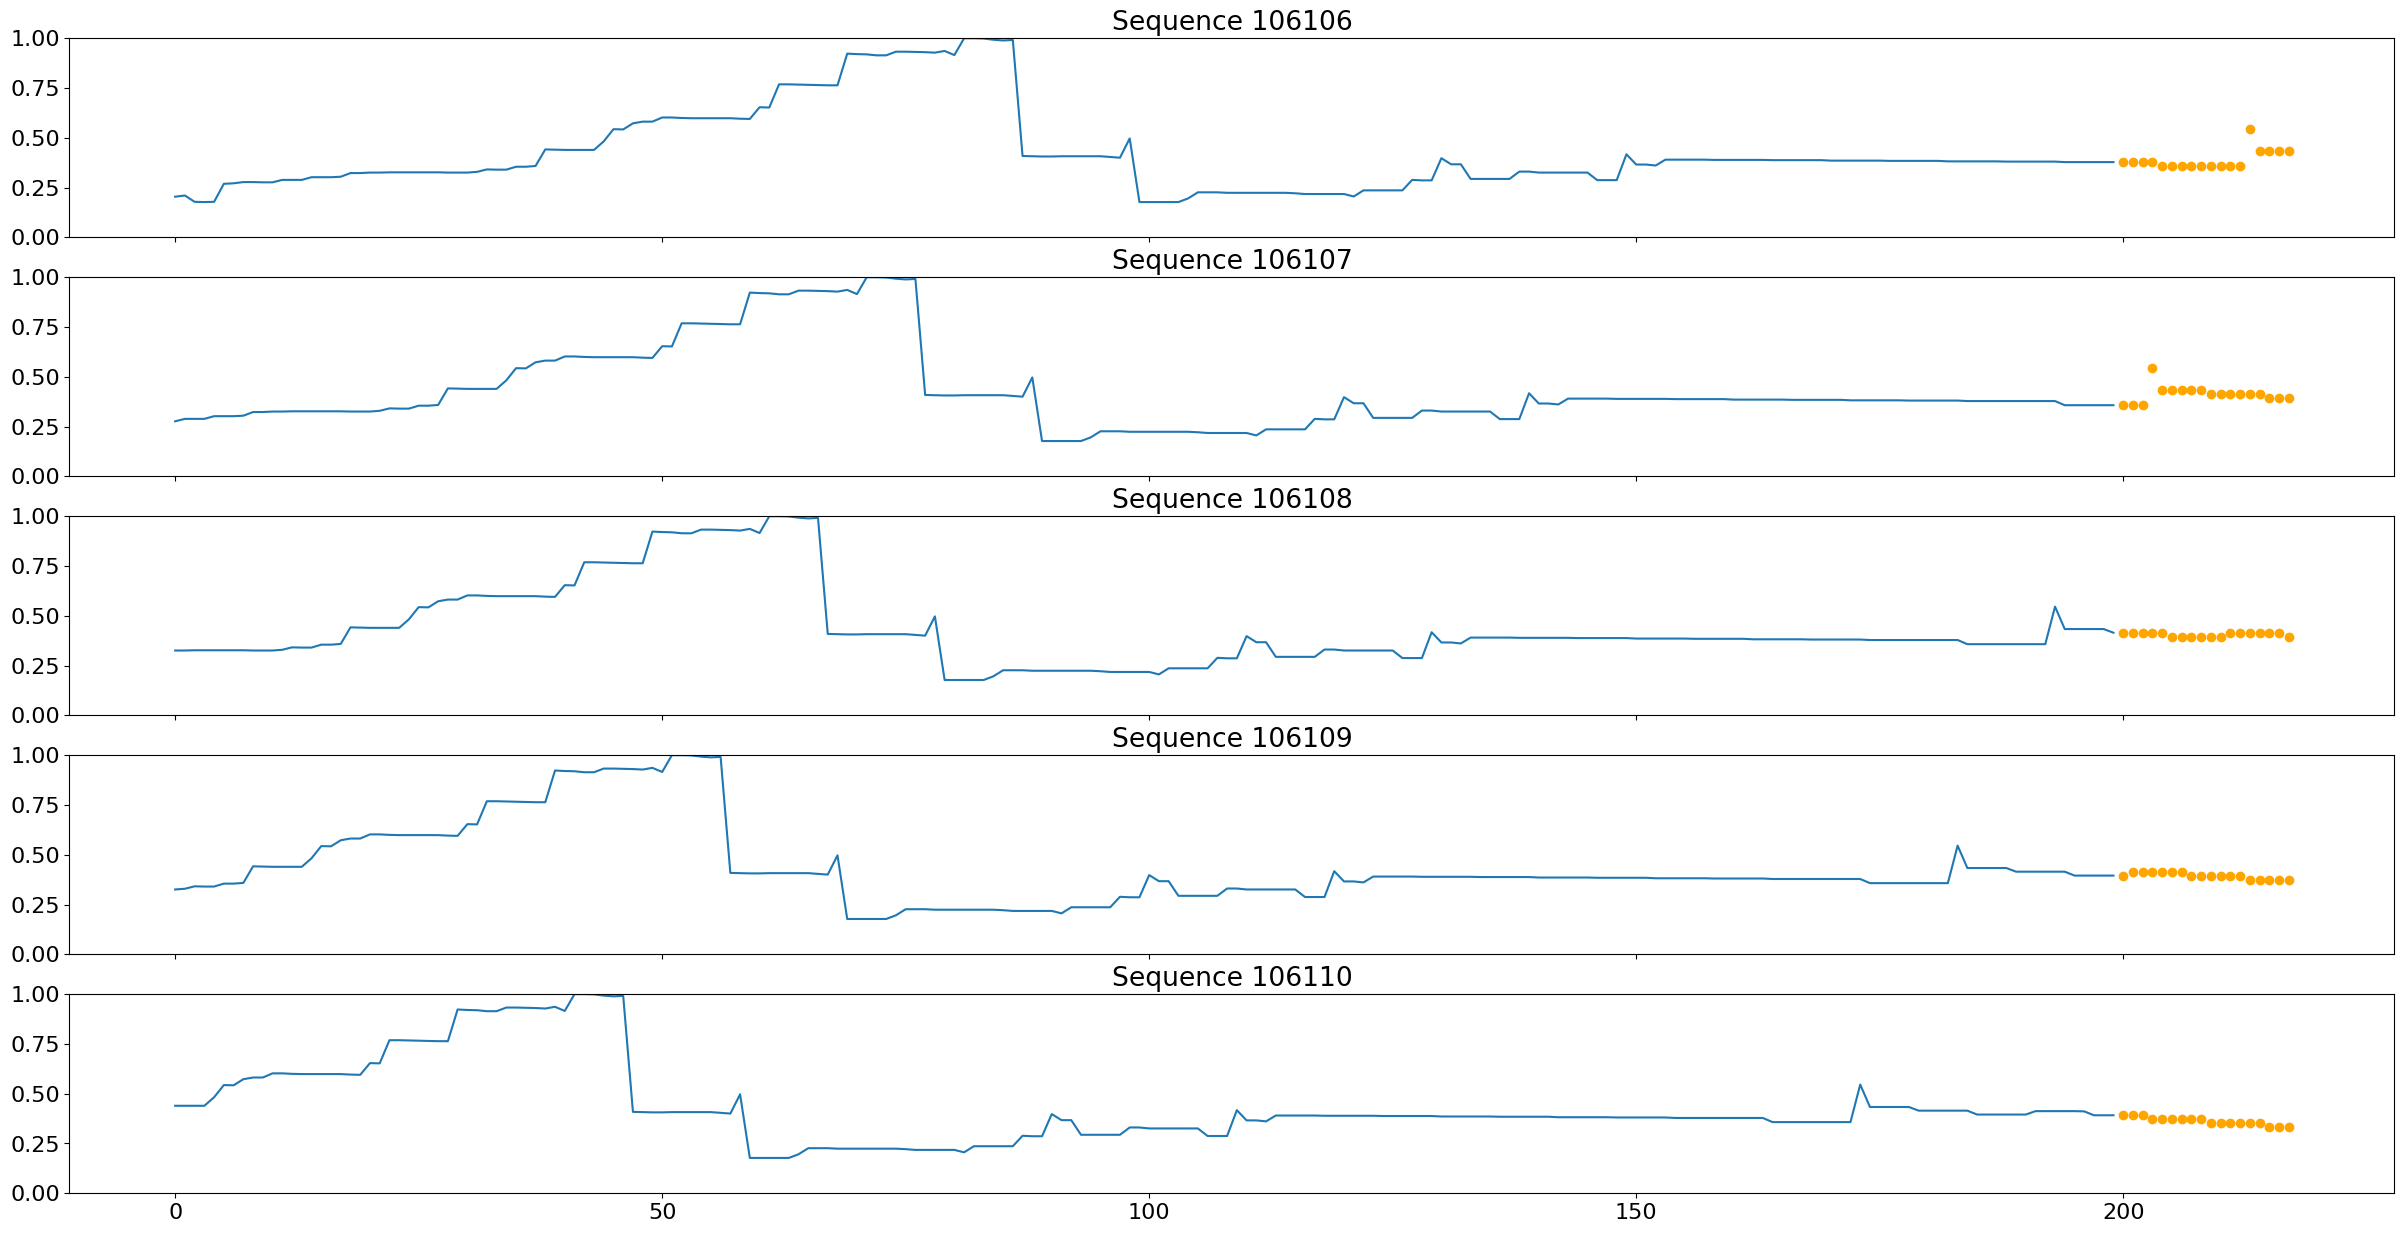

In [ ]:
inspect_multivariate(X_train, y_train, TELESCOPE)

In [ ]:
# Define input and output shape for the forecasting model

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
print(input_shape)
print(output_shape)

# Define a convolutional block with optional batch normalization
# (Code taken form extra material folder on CNN)
def conv_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=False, name=''):

    # If downsample is True, apply average-pooling
    if downsample:
        x = tfkl.AveragePooling1D(name='AvePool_' + name)(x)

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x = tfkl.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x)
        if batch_norm:
            x = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x)
        x = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x)


    return x

(200, 1)
(18, 1)


In [ ]:

# -----------------------------------* FORECASTING MODEL DEFINITION     *---------------------------------------

def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv1D(filters=32, kernel_size=3, padding='same', name='Conv0')(x)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create blocks
    x1 = conv_block(x=x0, filters=64, kernel_size=5, downsample=True, stack=1, name='1')
    x1 = conv_block(x=x1, filters=128, kernel_size=7, downsample=True, stack=1, name='2')
    x1 = conv_block(x=x1, filters=256, kernel_size=7, downsample=True, stack=1, name='3')
    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(1, 11 , padding='same', name='output_layer')(x1)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate =0.001))

    return model


# -----------------------------------* LR SCHEDULER  *---------------------------------------


def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = np.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate

# Define callback for learning rate scheduler and warmup

class WarmupCosineDecay(tfk.callbacks.Callback):
    def __init__(self, total_steps=0, warmup_steps=0, start_lr=0.0, target_lr=1e-3, hold=0):

        super(WarmupCosineDecay, self).__init__()
        self.start_lr = start_lr
        self.hold = hold
        self.total_steps = total_steps
        self.global_step = 0
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.lrs = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = model.optimizer.lr.numpy()
        self.lrs.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = lr_warmup_cosine_decay(global_step=self.global_step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)
        tfk.backend.set_value(self.model.optimizer.lr, lr)



total_steps = len(X_train)/BATCH_SIZE *EPOCHS

warmup_steps = int(0.05*total_steps)


# Print learning rate on tensorboard: write appropriate callback

class LRTensorBoard(TensorBoard):
    # add other arguments to __init__ if you need
    def __init__(self, log_dir, **kwargs):
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super().on_epoch_end(epoch, logs)


Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 Conv0 (Conv1D)              (None, 200, 32)           12320     
                                                                 
 BatchNorm0 (BatchNormaliza  (None, 200, 32)           128       
 tion)                                                           
                                                                 
 ReLU0 (Activation)          (None, 200, 32)           0         
                                                                 
 AvePool_1 (AveragePooling1  (None, 100, 32)       

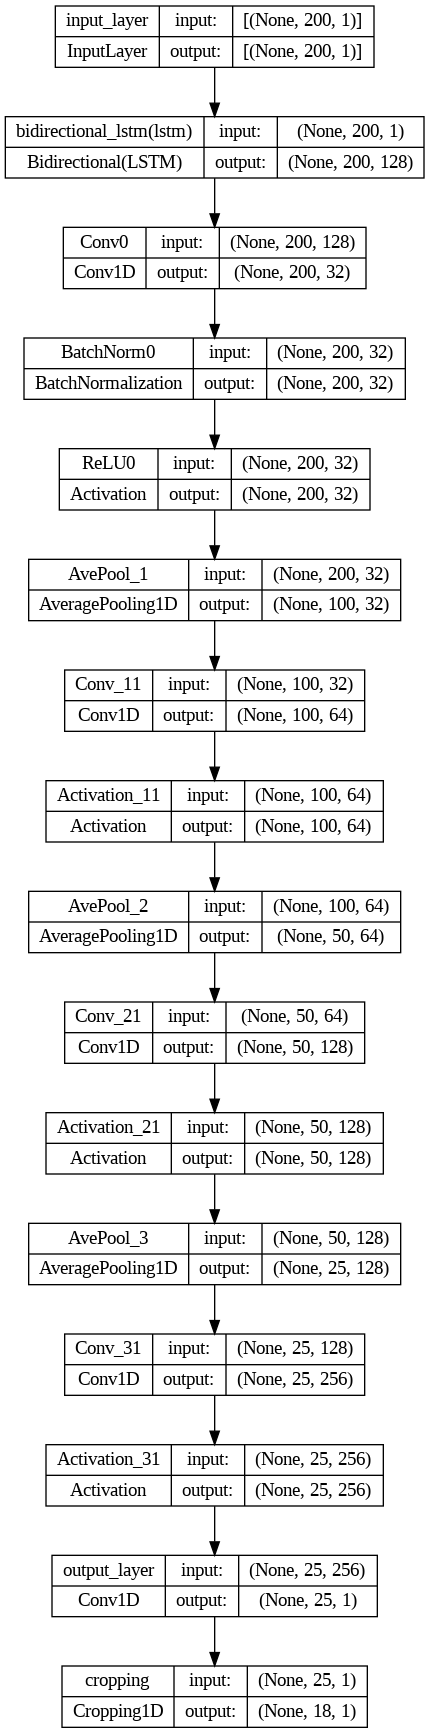

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-6)
    ],
    class_weight=weights
).history

Epoch 1/200
331/331 [==============================] - 25s 57ms/step - loss: 5.0094e-06 - val_loss: 0.0779 - lr: 0.0010
Epoch 2/200
331/331 [==============================] - 18s 55ms/step - loss: 2.1430e-06 - val_loss: 0.0152 - lr: 0.0010
Epoch 3/200
331/331 [==============================] - 18s 54ms/step - loss: 1.8177e-06 - val_loss: 0.0145 - lr: 0.0010
Epoch 4/200
331/331 [==============================] - 18s 54ms/step - loss: 1.6937e-06 - val_loss: 0.0170 - lr: 0.0010
Epoch 5/200
331/331 [==============================] - 18s 53ms/step - loss: 1.6435e-06 - val_loss: 0.0211 - lr: 0.0010
Epoch 6/200
331/331 [==============================] - 18s 54ms/step - loss: 1.6453e-06 - val_loss: 0.0296 - lr: 0.0010
Epoch 7/200
331/331 [==============================] - 18s 54ms/step - loss: 1.6347e-06 - val_loss: 0.0264 - lr: 0.0010
Epoch 8/200
331/331 [==============================] - 18s 54ms/step - loss: 1.5771e-06 - val_loss: 0.0127 - lr: 0.0010
Epoch 9/200
331/331 [===================

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (7359, 18, 1)
Mean Squared Error: 0.010133547708392143
Mean Absolute Error: 0.06592434644699097


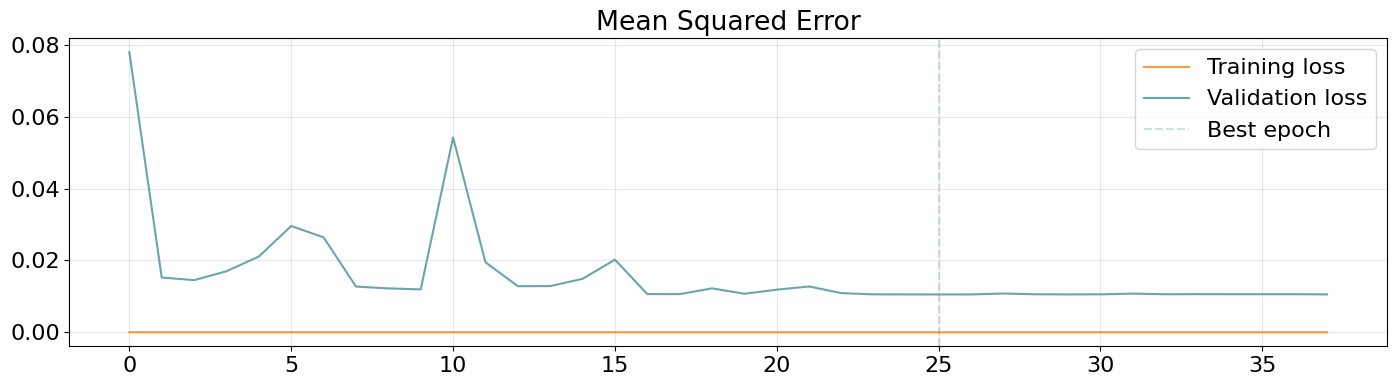

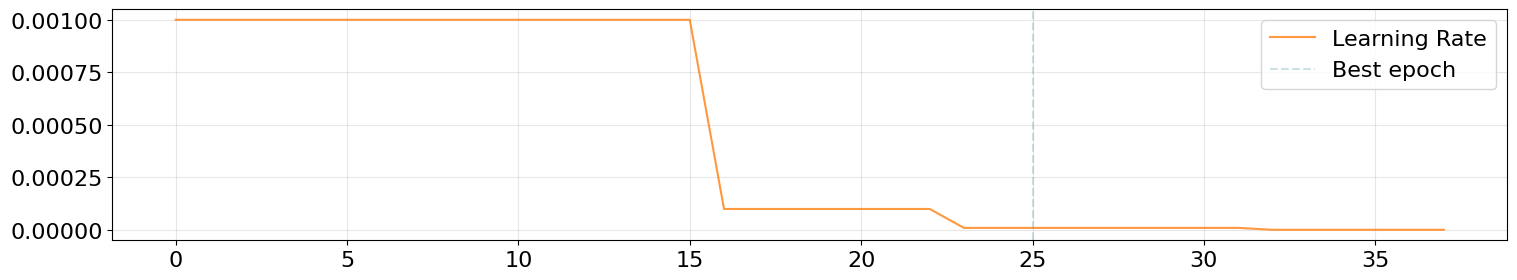

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

model.save("Second_Attempt/SecondAttempt")

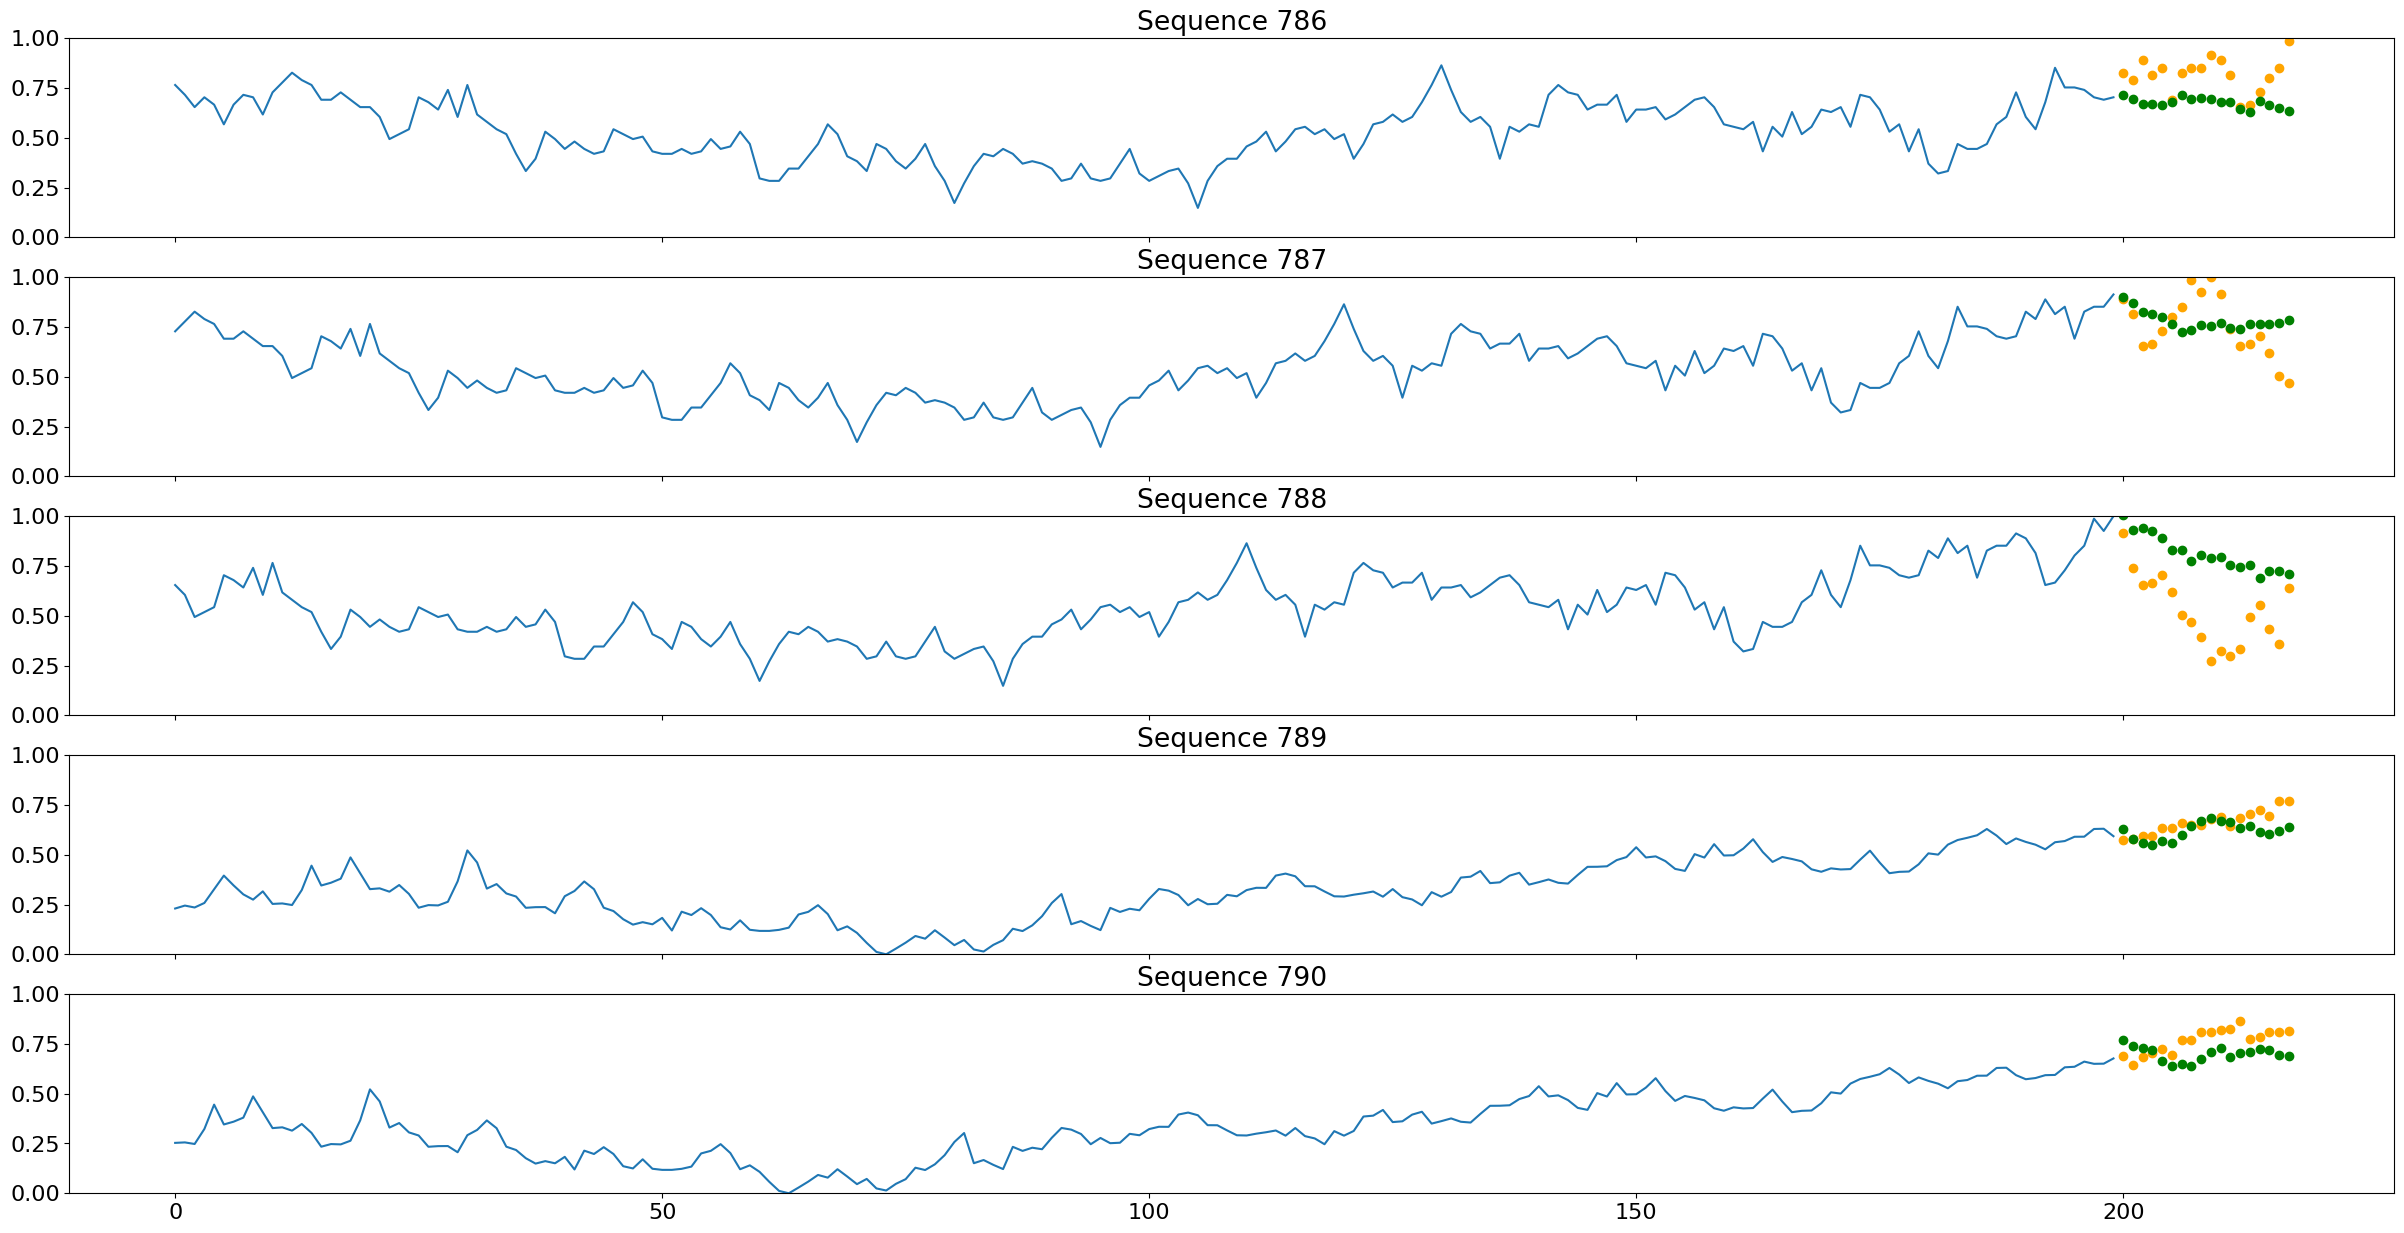

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, TELESCOPE)

In [ ]:
del model

In [ ]:
model = tfk.models.load_model('Second_Attempt/SecondAttempt')

out = model.predict(X_test)  # Shape [BSx9] for Phase 1 and [BSx18] for Phase 2

# Keep just the first 9 values
out = out[:, :9]


# Do the same for the y_test
y_test = y_test[:, :9]


# Print the shape of the predictions
print(f"Predictions shape: {out.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), out.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), out.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

out = tf.squeeze(out)

print(out.shape)